# Introduction

This project came to life when I, out of the blue, hit a serious case of certification fatigue. I decided that it was time to experiment, and play around a bit, focusing on having fun and not on completing certifications and courses. 

After searhing around for a good dataset, I ended up with these two data sets from Stavanger. They are open for the public. They contain data on the hourly coverage/usage of different parking spots in Stavanger. There is a datapoint for each our every day for each parking lot. One dataset contains the data from 2017, the other from 2018. 

## Preliminaries 

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

parkinglots = ['Siddis', 'Forum', 'Jernbanen', 'Posten', 'Jorenholmen', 'St. Olav', 'Valberget', 'Kyrre', 'Parketten']
colors = ['teal', 'green', 'red', 'blue', 'red', 'purple', 'orange', 'yellow', 'pink']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = ['00','01','02','03','04','05','06','07','08','09', '10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hours_every_other = ['00',' ','02',' ','04',' ','06',' ','08',' ','10',' ','12',' ','14',' ','16',' ','18',' ','20',' ','22', ' ']

def fix_date(date):
    '''
    Helper function that reformats the Dates to a format that can then be converted to a datetime object
    '''
    day = str(date[0])
    month= str(date[1])
    year = '20' + str(date[2])

    #English-ify the months:
    
    if month == 'mai':
        month = 'may'
    elif month == 'okt':
        month = 'oct'
    elif month == 'des':
        month = 'dec'
    return year + '-' + month + '-' + day

## 2018: reading and cleaning

In [172]:
parkering2018 = pd.read_csv('parkering2018.csv')
parkering2018.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,1-jan-18,0:00,"3,0","0,0","19,0","11,0","17,0","22,0","12,0","14,0","13,0"
1,1-jan-18,1:00,"3,0","0,0","18,0","5,0","14,0","21,0","10,0","15,0","13,0"
2,1-jan-18,2:00,"2,0","0,0","17,0","6,0","15,0","21,0","6,0","15,0","4,0"
3,1-jan-18,3:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"
4,1-jan-18,4:00,"2,0","0,0","17,0","5,0","15,0","21,0","6,0","15,0","3,0"


In [173]:
#Fixing the dates, and adding date+time in a seperate column as a datetime object

parkering2018['Dato'] = parkering2018['Dato'].str.split('-')
parkering2018['Tidspunkt'] = parkering2018['Dato'].apply(fix_date) + ' ' + parkering2018['Tid']
parkering2018['Tidspunkt'] = pd.to_datetime(parkering2018['Tidspunkt'])

# Converting the numericals to ratios (floating numbers between 0 and 1)
for lot in parkinglots:
    parkering2018[lot] = parkering2018[lot].str.replace(',','.')
    parkering2018[lot] = parkering2018[lot].astype('float32')
    parkering2018[lot] = parkering2018[lot]/100

#trekker ut mnd for senere bruk
parkering2018['Month'] = parkering2018['Tidspunkt'].dt.month # jan=1, ..., dec=12

#making sure we dont have any negative values
parkering2018.describe()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_12084\3918694934.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month
count,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752,7752.000000
mean,0.157153,0.175481,0.239265,0.336419,0.310633,0.364702,0.381303,0.257722,0.186117,2018-06-11 22:53:09.938080256,5.864293
min,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.020000,0.000000,2018-01-01 00:00:00,1.000000
25%,0.060000,0.010000,0.110000,0.050000,0.160000,0.190000,0.200000,0.100000,0.040000,2018-03-23 06:45:00,3.000000
50%,0.110000,0.090000,0.190000,0.240000,0.260000,0.320000,0.330000,0.190000,0.105000,2018-06-12 01:30:00,6.000000
75%,0.190000,0.220000,0.350000,0.590000,0.410000,0.520000,0.500000,0.350000,0.260000,2018-08-31 19:15:00,8.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2018-11-20 12:00:00,11.000000
std,0.162794,0.235740,0.182612,0.317887,0.194967,0.202108,0.239830,0.207766,0.199809,NaN,3.072202


## 2017: reading and cleaning
Mostly the same steps as for 2018. We uncovered one error in the dataset, which we needed to account for. It was the registration for Feb 15th 02:00, which was done at 02:01 instead. We replaced 02:01 woth 02:00, as the error caused issues down the line when we wanted to group the data on `Tid`.

In [174]:
parkering2017 = pd.read_csv('parkering2017.csv')
parkering2017['Dato'] = parkering2017['Dato'].str.split('-')
# print(parkering2017.isna().sum())
parkering2017 = parkering2017.dropna() #one row with pure NaN
parkering2017.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten
0,"[1, jan, 17]",0:00,"2,0","0,0","16,0","15,0","15,0","21,0","8,0","18,0","4,0"
1,"[1, jan, 17]",1:00,"2,0","0,0","11,0","6,0","12,0","19,0","7,0","17,0","4,0"
2,"[1, jan, 17]",2:00,"2,0","0,0","11,0","4,0","12,0","18,0","6,0","18,0","4,0"
3,"[1, jan, 17]",3:00,"2,0","0,0","11,0","3,0","12,0","18,0","6,0","17,0","4,0"
4,"[1, jan, 17]",4:00,"2,0","0,0","11,0","2,0","12,0","17,0","5,0","17,0","4,0"


In [175]:
# # Feb 15th have a registration at 02:01 instead of 02:00
parkering2017['Tid'] = parkering2017['Tid'].replace({
    '2:01': '2:00'
})

parkering2017['Tid'].unique() #validating the fix

array(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00',
       '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

In [176]:
parkering2017['Tidspunkt'] = parkering2017['Dato'].apply(fix_date) + ' ' + parkering2017['Tid']
parkering2017['Tidspunkt'] = pd.to_datetime(parkering2017['Tidspunkt'])

for lot in parkinglots:
    parkering2017[lot] = parkering2017[lot].str.replace(',','.')
    parkering2017[lot] = parkering2017[lot].astype('float32')
    parkering2017[lot] = parkering2017[lot]/100


parkering2017['Month'] = parkering2017['Tidspunkt'].dt.month # jan=1, ..., dec=12
parkering2017.head()

C:\Users\lenelise\AppData\Local\Temp\ipykernel_12084\4132017881.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month
0,"[1, jan, 17]",0:00,0.02,0.0,0.16,0.15,0.15,0.21,0.08,0.18,0.04,2017-01-01 00:00:00,1
1,"[1, jan, 17]",1:00,0.02,0.0,0.11,0.06,0.12,0.19,0.07,0.17,0.04,2017-01-01 01:00:00,1
2,"[1, jan, 17]",2:00,0.02,0.0,0.11,0.04,0.12,0.18,0.06,0.18,0.04,2017-01-01 02:00:00,1
3,"[1, jan, 17]",3:00,0.02,0.0,0.11,0.03,0.12,0.18,0.06,0.17,0.04,2017-01-01 03:00:00,1
4,"[1, jan, 17]",4:00,0.02,0.0,0.11,0.02,0.12,0.17,0.05,0.17,0.04,2017-01-01 04:00:00,1


# Visualization

## Hourly averages 2018

In [177]:
#Hourly averages for each lot for each year
# List of Series objects, one for each lot
parkinglots_hourly_avg_2017 = [] 
parkinglots_hourly_avg_2018 = [] 

for lot in parkinglots: 
    parkinglots_hourly_avg_2017.append(parkering2017.groupby('Tid')[lot].mean())
    parkinglots_hourly_avg_2018.append(parkering2018.groupby('Tid')[lot].mean())

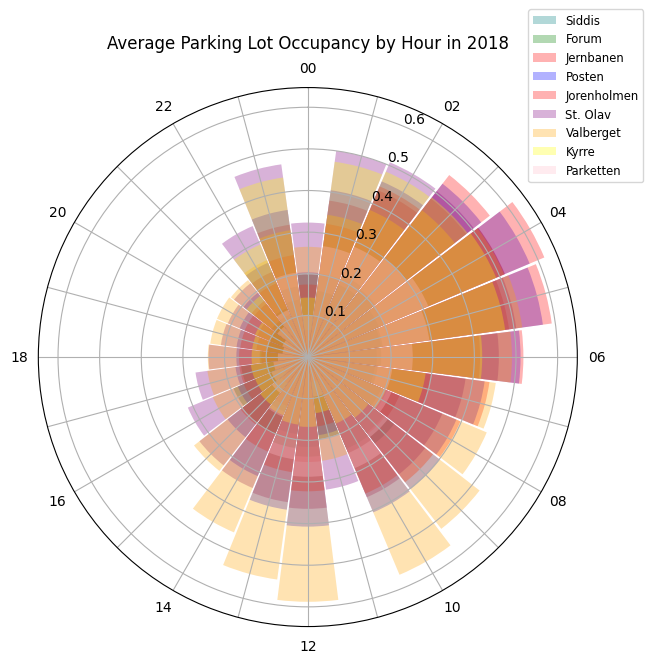

In [178]:
#The plotting
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False) #deler opp sirkel (2*pi) i 24 like store deler
fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection': 'polar'})

i=0
for lot_avg in parkinglots_hourly_avg_2018:
    bars = ax.bar(angles, parkinglots_hourly_avg_2018[i].values, width=0.25, color=colors[i], alpha=0.3, label=parkinglots[i]) #alpha styrer gjennomsiktighetsgraden
    i += 1

# ax.legend(loc='best', fontsize='x-small', draggable=True)
ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,1), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser

# Optional: Customize
ax.set_theta_zero_location("N")  # 12 o'clock starts at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Average Parking Lot Occupancy by Hour in 2018", va='bottom')
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)

plt.show()

### The same, just in plotly

**Note:** Plotly express does not support multiple traces (graphs) in the same figure. For that we need to use Plotly Graph Objects.

In [179]:
angles360 = np.linspace(0, 360, 24, endpoint=False) #deler opp sirkel (360) i 24 like store deler

fig = px.bar_polar(
    parkering2018,
    r = parkering2018.groupby('Tid')['Siddis'].mean().values,
    theta = angles360, 
    color=parkering2018.groupby('Tid')['Siddis'].mean().values
)

fig.update_traces(overwrite=True, marker={"opacity": 0.4})

fig.show()

## 2017 vs 2018

In [180]:
parkering2018.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month
0,"[1, jan, 18]",0:00,0.03,0.0,0.19,0.11,0.17,0.22,0.12,0.14,0.13,2018-01-01 00:00:00,1
1,"[1, jan, 18]",1:00,0.03,0.0,0.18,0.05,0.14,0.21,0.10,0.15,0.13,2018-01-01 01:00:00,1
2,"[1, jan, 18]",2:00,0.02,0.0,0.17,0.06,0.15,0.21,0.06,0.15,0.04,2018-01-01 02:00:00,1
3,"[1, jan, 18]",3:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 03:00:00,1
4,"[1, jan, 18]",4:00,0.02,0.0,0.17,0.05,0.15,0.21,0.06,0.15,0.03,2018-01-01 04:00:00,1


In [181]:
parkering2017.head()

,Dato,Tid,Siddis,Forum,Jernbanen,Posten,Jorenholmen,St. Olav,Valberget,Kyrre,Parketten,Tidspunkt,Month
0,"[1, jan, 17]",0:00,0.02,0.0,0.16,0.15,0.15,0.21,0.08,0.18,0.04,2017-01-01 00:00:00,1
1,"[1, jan, 17]",1:00,0.02,0.0,0.11,0.06,0.12,0.19,0.07,0.17,0.04,2017-01-01 01:00:00,1
2,"[1, jan, 17]",2:00,0.02,0.0,0.11,0.04,0.12,0.18,0.06,0.18,0.04,2017-01-01 02:00:00,1
3,"[1, jan, 17]",3:00,0.02,0.0,0.11,0.03,0.12,0.18,0.06,0.17,0.04,2017-01-01 03:00:00,1
4,"[1, jan, 17]",4:00,0.02,0.0,0.11,0.02,0.12,0.17,0.05,0.17,0.04,2017-01-01 04:00:00,1


In [182]:
jan2017 = parkering2017[ parkering2017['Tidspunkt'].dt.month == 1]

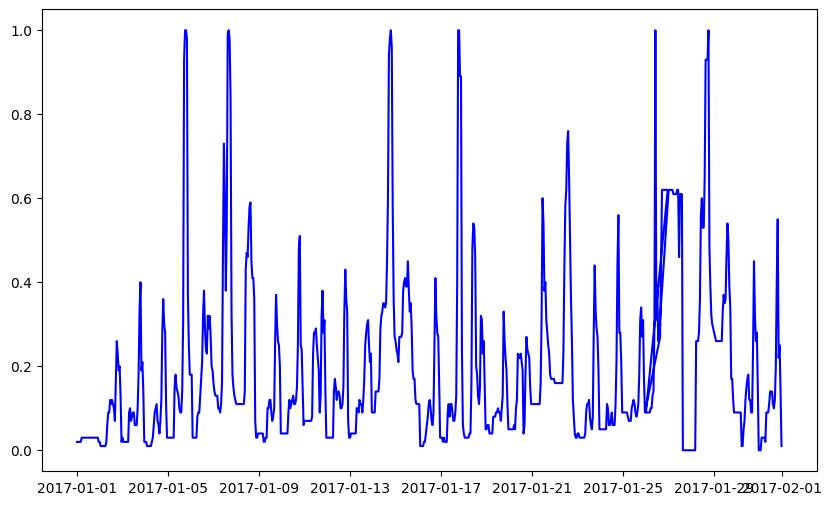

In [183]:
x1 = jan2017['Tidspunkt']
x2 = parkering2018['Tidspunkt']

y1 = jan2017['Siddis']
y2 = parkering2018['Siddis']

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(x1,y1,'b')
# ax.plot(x2,y2,'b')

plt.show()

## Siddis 2017 vs 2018

In [184]:
Siddis_hour_average_2017 = parkering2017.groupby('Tid')['Siddis'].mean()
Siddis_hour_average_2018 = parkering2018.groupby('Tid')['Siddis'].mean()

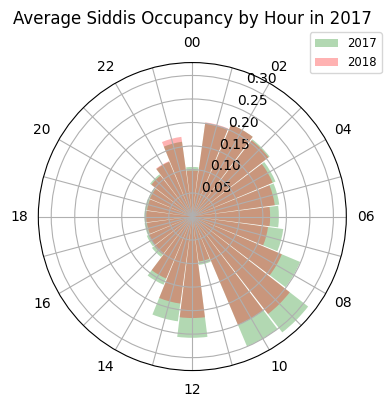

In [185]:
#The plotting
fig, ax = plt.subplots(figsize=(4,4), subplot_kw={'projection': 'polar'})

bars = ax.bar(angles, Siddis_hour_average_2017, width=0.25, color=colors[1], alpha=0.3, label='2017') #alpha styrer gjennomsiktighetsgraden
bars = ax.bar(angles, Siddis_hour_average_2018, width=0.25, color=colors[2], alpha=0.3, label ='2018') #alpha styrer gjennomsiktighetsgraden

ax.legend(loc='best', fontsize='small', bbox_to_anchor=(1,0.97), bbox_transform = fig.transFigure) #plasseres ut fra figurens akser, ikke Axes' akser

# Optional: Customize
ax.set_theta_zero_location("N")  # 12 o'clock starts at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_xticks(angles)
ax.set_xticklabels(hours_every_other)
ax.set_title("Average Siddis Occupancy by Hour in 2017", va='bottom')

plt.show()

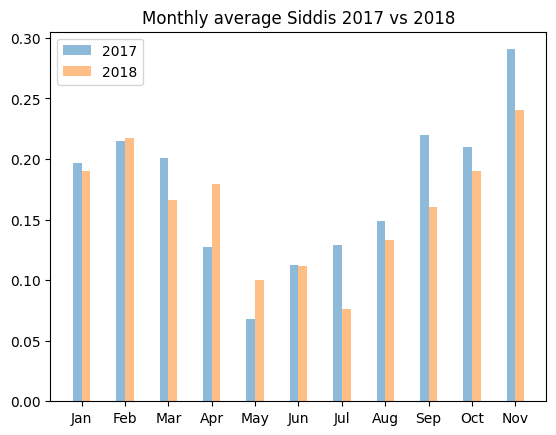

In [186]:
## Siddis occupancy by monthly averages
siddis_monthly_average_2017 = parkering2017.groupby('Month')['Siddis'].mean()
siddis_monthly_average_2018 = parkering2018.groupby('Month')['Siddis'].mean() #2018 mangler data for desember

fig,ax = plt.subplots()

w, x = 0.2, np.arange(len(months)-1)

# ax.bar(months[:-1], siddis_monthly_average_2017.values[:-1], label='2017', width=0.2, alpha=0.5)
# ax.bar(months[:-1], siddis_monthly_average_2018.values, label='2018', width=0.2, alpha=0.5)
ax.bar(x-w/2, siddis_monthly_average_2017.values[:-1], label='2017', width=0.2, alpha=0.5)
ax.bar(x+w/2, siddis_monthly_average_2018.values, label='2018', width=0.2, alpha=0.5)

ax.set_xticks(ticks=x, labels=months[:-1])
ax.set_title("Monthly average Siddis 2017 vs 2018")
ax.legend()

plt.show()